In [64]:
import pandas as pd
import keras
import numpy as np
from keras import layers
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load and preprocess the data
data = pd.read_csv('csv/tiny_accel_gyro.csv')

# Separate features and labels
input_data = data.drop(columns=['label']).values
output_data = data['label'].values

# Encode labels to one-hot
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(output_data)
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
output_data = onehot_encoder.fit_transform(integer_encoded)

# Standardize the input features
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)

In [80]:
# Define the MLP model architecture
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(input_data.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(output_data.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

E:\HEIG\ARN\Labo3\ARN-3\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
# Load and preprocess the validation data
validation_file_path = 'csv/tiny_valid_accel_gyro.csv'
validation_data = pd.read_csv(validation_file_path)

# Separate features and labels for validation data
X_validation = validation_data.drop(columns=['label']).values
y_validation = validation_data['label'].values

# Encode labels to one-hot for validation data
integer_encoded_val = label_encoder.transform(y_validation)
integer_encoded_val = integer_encoded_val.reshape(len(integer_encoded_val), 1)
y_validation_onehot = onehot_encoder.transform(integer_encoded_val)

# Standardize the input features for validation data
X_validation = scaler.transform(X_validation)

Average Training Loss: 0.1458236277103424
Average Training Accuracy: 0.9570000171661377
Average Validation Loss: 0.8743360161781311
Average Validation Accuracy: 0.7524752497673035


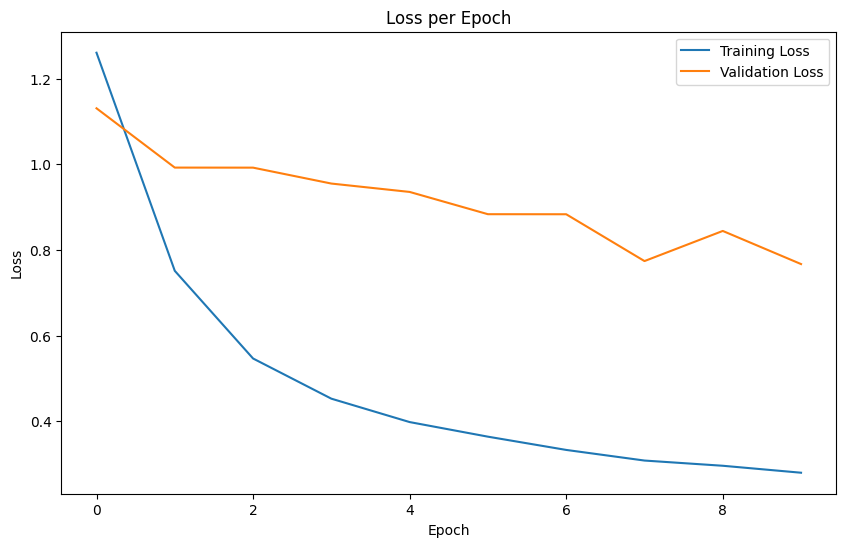

In [82]:
# Perform K-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True)

# Initialize lists to store the evaluation results and loss history
loss_scores = []
accuracy_scores = []
val_loss_scores = []
val_accuracy_scores = []
loss_history = []
val_loss_history = []

# Iterate over each fold
for train_index, test_index in kf.split(input_data):
    # Split the data into training and test sets
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = output_data[train_index], output_data[test_index]

    # Train the model on the training set and store loss history
    history = model.fit(X_train, y_train, epochs=2, batch_size=32, verbose=0, validation_data=(X_validation, y_validation_onehot))

    # Record the loss after each epoch
    loss_history.extend(history.history['loss'])
    val_loss_history.extend(history.history['val_loss'])

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_validation, y_validation_onehot, verbose=0)

    # Store the evaluation results
    loss_scores.append(loss)
    accuracy_scores.append(accuracy)
    val_loss_scores.append(val_loss)
    val_accuracy_scores.append(val_accuracy)

# Calculate the average evaluation scores
avg_loss = np.mean(loss_scores)
avg_accuracy = np.mean(accuracy_scores)
avg_val_loss = np.mean(val_loss_scores)
avg_val_accuracy = np.mean(val_accuracy_scores)

print("Average Training Loss:", avg_loss)
print("Average Training Accuracy:", avg_accuracy)
print("Average Validation Loss:", avg_val_loss)
print("Average Validation Accuracy:", avg_val_accuracy)

# Plot the loss values after each epoch
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


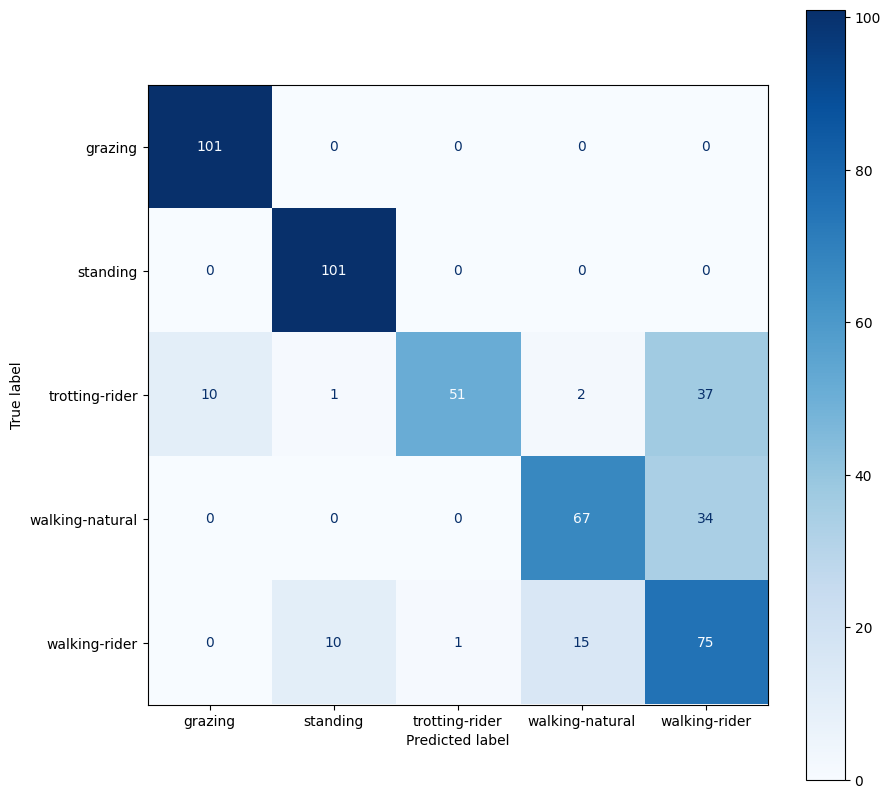

In [84]:
# Load and preprocess the validation data
validation_file_path = 'csv/tiny_valid_accel_gyro.csv'
validation_data = pd.read_csv(validation_file_path)

# Separate features and labels for validation data
X_validation = validation_data.drop(columns=['label']).values
y_validation = validation_data['label'].values

# Encode labels to one-hot for validation data
integer_encoded_val = label_encoder.transform(y_validation)
integer_encoded_val = integer_encoded_val.reshape(len(integer_encoded_val), 1)
y_validation_onehot = onehot_encoder.transform(integer_encoded_val)

# Standardize the input features for validation data
X_validation = scaler.transform(X_validation)

# Predict on the validation set
y_pred = model.predict(X_validation)

# Convert predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_validation_onehot, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

# Plot the confusion matrix with a larger figure size
plt.figure(figsize=(10, 10))  # Adjust the figsize to your preference
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), values_format='d')
plt.show()

# Export

In [21]:
def weights_to_cpp(model, filename="weights_and_biases.txt"):
    model.summary()
    weights = []
    biases = []
    
    for layer in model.layers:
        layer_weights = layer.get_weights()
        if len(layer_weights) == 2:
            W, B = layer_weights
        elif len(layer_weights) == 1:
            W = layer_weights[0]
            B = np.array([])
        else:
            continue  # Skip layers that do not have 1 or 2 sets of weights
        weights.append(W.flatten())
        biases.append(B.flatten())

    # Flatten the lists of weights and biases
    z = np.concatenate(weights).tolist()
    b = np.concatenate(biases).tolist()
    
    with open(filename, "w") as f:
        f.write("weights: {")
        for i in range(len(z)):
            if i < len(z) - 1:
                f.write(str(z[i]) + ", ")
            else:
                f.write(str(z[i]))
        f.write("}\n\n")

        f.write("biases: {")
        for i in range(len(b)):
            if i < len(b) - 1:
                f.write(str(b[i]) + ", ")
            else:
                f.write(str(b[i]))
        f.write("}\n\n")
    
        arch = []
        arch.append(model.input_shape[1])
        for layer in model.layers:
            if isinstance(layer, layers.Dense):
                arch.append(layer.units)
        
        f.write("Architecture: {")
        for i in range(len(arch)):
            if i < len(arch) - 1:
                f.write(str(arch[i]) + ", ")
            else:
                f.write(str(arch[i]))
        f.write("}")
    
        print("Architecture (alpha):", arch)
        print("Layers: ", len(arch))
    
    print("Weights: ", z)
    print("Biases: ", b)



# Exportation des poids et des biais

In [86]:
weights_to_cpp(model, "weights_and_biases.txt")

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,433 (17.32 KB)

 Trainable params: 1,477 (5.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,956 (11.55 KB)

Architecture (alpha): [7, 32, 32, 5]
Layers:  4
Weights:  [-0.7376832365989685, 0.09573083370923996, 0.27120068669319153, 0.32966965436935425, -0.588050127029419, 0.4072917103767395, -0.3047785758972168, 0.10314637422561646, -0.033563755452632904, 0.38234975934028625, 0.19995707273483276, 0.10876203328371048, 0.04040900990366936, 0.4286259114742279, 0.5278589129447937, -0.11785854399204254, -0.4559314548969269, 0.10201910883188248, 0.08145920187234879, 0.4563557207584381, 0.22714659571647644, 0.319743275642395, 0.09830570966005325, 0.4350428581237793, -0.5627998113632202, -0.5236803293228149, 0.1917017549276352, -0.033688608556985855, -0.5325575470924377, 0.30029791593551636, 0.13434436917304993, -0.7501698136329651, -0.32730522751808167, -0.6844851970672607, -0.0641084760427475, 0.16451114416122437, -0.15139786899089813, -0.3456636965274811, -0.11777859926223755, 0.34521088004112244, -0.5743808746337891, 0.4343908131122589, 0.7320302724838257, 0.17848597466945648, 0.6573740243911743, 

# Génération de code C++

In [85]:
# Load and preprocess the CSV data
data = pd.read_csv('csv/tiny.csv')
input_data = data.drop(columns=['label']).values
output_labels = data['label'].unique()

# Encode labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(output_labels)
encoded_labels = label_encoder.transform(data['label'].values)

# Select a sample input for testing
sample_input = input_data[0]

# Extract model parameters
def extract_parameters(model):
    weights = []
    biases = []
    for layer in model.layers:
        layer_weights = layer.get_weights()
        if len(layer_weights) == 2:
            W, B = layer_weights
        elif len(layer_weights) == 1:
            W = layer_weights[0]
            B = np.array([])
        else:
            continue
        weights.append(W.flatten())
        biases.append(B.flatten())
    return np.concatenate(weights), np.concatenate(biases)

weights, biases = extract_parameters(model)

# Prepare C++ code format
topology = [model.input_shape[1]]
for layer in model.layers:
    if isinstance(layer, layers.Dense):
        topology.append(layer.units)

cpp_code = f"""
#include "MicroFlow.h"

void setup() {{
  Serial.begin(9600);

  int topology[] = {{{', '.join(map(str, topology))}}};
  double weights[] = {{{', '.join(map(str, weights))}}};
  double biases[] = {{{', '.join(map(str, biases))}}};
  double inputs[] = {{{', '.join(map(str, sample_input))}}};
  double output[{topology[-1]}] = {{}};

  MicroMLP mlp(sizeof(topology)/sizeof(topology[0]), topology, weights, biases, SIGMOID);

  mlp.feedforward(inputs, output);

  Serial.print("Inputs: ");
  for (int i = 0; i < sizeof(inputs) / sizeof(inputs[0]); i++) {{
    Serial.print(inputs[i]);
    if (i < sizeof(inputs) / sizeof(inputs[0]) - 1) {{
      Serial.print(", ");
    }}
  }}
  Serial.println();

  Serial.print("Neural Network Output: ");
  for (int i = 0; i < sizeof(output) / sizeof(output[0]); i++) {{
    Serial.print(output[i]);
    if (i < sizeof(output) / sizeof(output[0]) - 1) {{
      Serial.print(", ");
    }}
  }}
  Serial.println();

  const char* labels[] = {{{', '.join(f'"{label}"' for label in label_encoder.classes_)}}};

  int max_index = 0;
  for (int i = 1; i < sizeof(output) / sizeof(output[0]); i++) {{
    if (output[i] > output[max_index]) {{
      max_index = i;
    }}
  }}

  Serial.print("Predicted Label: ");
  Serial.println(labels[max_index]);
}}

void loop() {{
  // Placeholder loop function
}}
"""

# Write the C++ code to a file
with open('model_parameters.cpp', 'w') as f:
    f.write(cpp_code)

print("C++ code has been generated and saved to model_parameters.cpp")

C++ code has been generated and saved to model_parameters.cpp
